# 3상모터 진동 데이터 정보

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from collections import Counter
import re

In [91]:
def load_csv(filename):
    with open(filename, encoding='utf8') as f:
        for idx, row in enumerate(f):
            col = row.split(',')
            if idx >= 9: # vib
                vib[idx - 9] = float(col[1])
            elif idx == 2: # label name 
                label_name = col[1].rstrip()
                # self.labels.append(label_name)
            elif idx == 3: # label no
                no = int(col[1])
                # self.idx_of_label.append(int(col[1]))
                # self.idx_to_label[int(col[1])] = label_name
            elif idx == 4: # motor spec
                rpm = int(col[2]) # rpm
                watt = float(col[3]) # watt
            elif idx == 5: # period
                p = re.compile('[0-9]').findall(col[1])
                if len(p) > 0 :
                    period = int(p[0])
                else:
                    period = 0
            elif idx == 6: #sample rate
                sample_rate = int(col[1])
            elif idx == 8:
                vib = np.zeros(int(col[1]))
            
    return np.array([vib]), label_name, no, rpm, watt, period, sample_rate

In [92]:
dataset_path = glob(os.path.join('dataset/vibration/train', '**/*.csv'), recursive=True)

In [93]:
for path in dataset_path:
    try:
        load_csv(path)
    except Exception as e:
        print(path)
        print(e)

dataset/vibration/train/11kW/L-CAHU-01R/normal/STFMK-20201105-LW19-1935_20201125_154315_004.csv
'utf-8' codec can't decode byte 0xb2 in position 4383: invalid start byte


In [22]:
classes = [ os.path.dirname(path).split('/')[-1] for path in dataset_path ]

### 클래스 종류 및 클래스 개수

In [23]:
num_classes = len(set(classes))
print('classes: ', set(classes))
print('number of classes: ' , num_classes)

classes:  {'def_shaft_alignment', 'normal', 'def_baring', 'loose_belt', 'rotating_unbalance'}
number of classes:  5


### 데이터 샘플

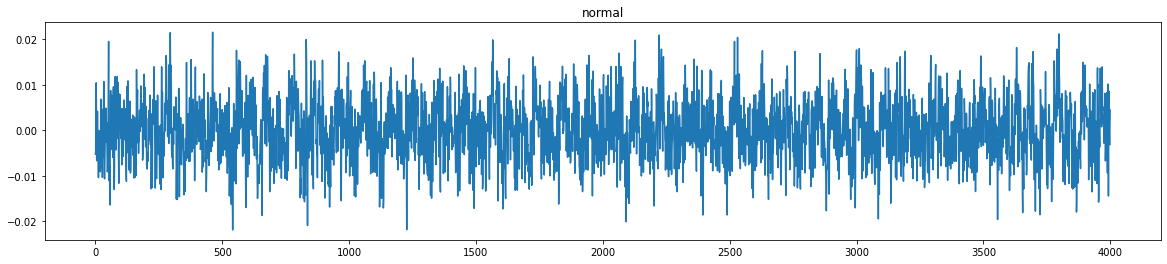

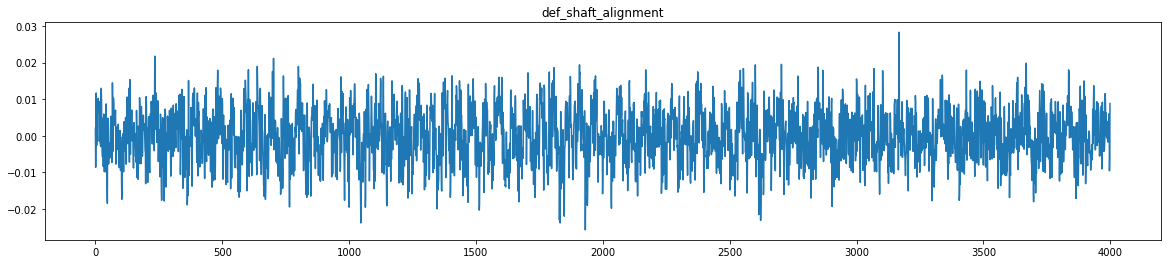

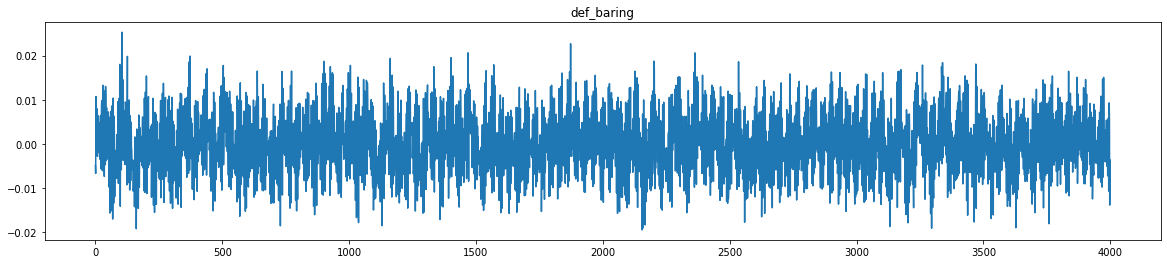

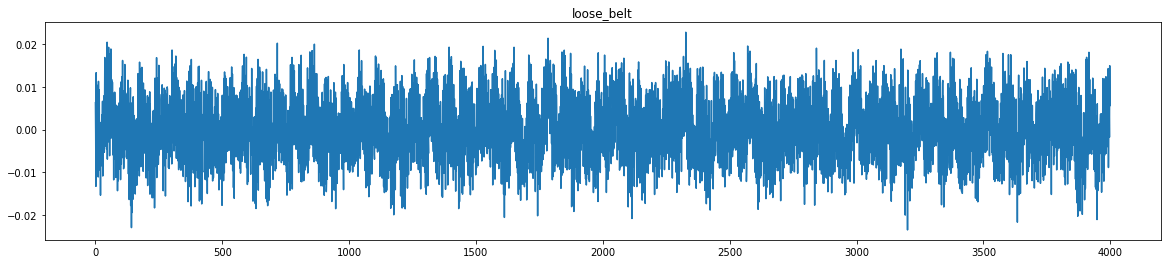

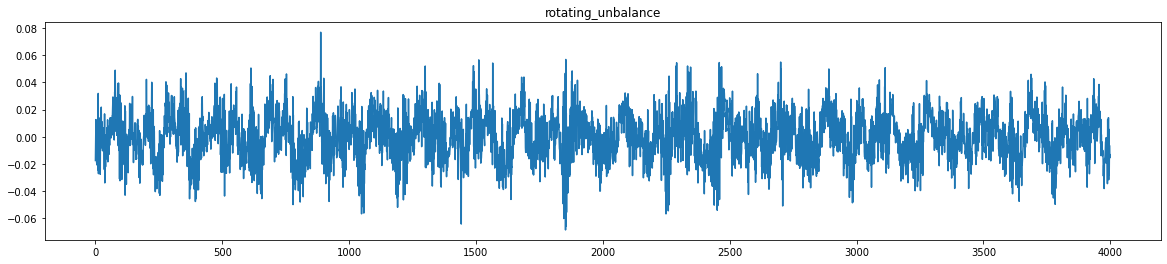

In [37]:
show_classes = []
for class_name, path in zip(classes, dataset_path):
    if class_name in show_classes:
        continue
    
    show_classes.append(class_name)
    
    csv = load_csv(path)   
    plt.figure(figsize=(20,4))
    plt.title(class_name)
    plt.plot(csv[0].reshape(csv[0].shape[1])[:4000])
    
    if len(show_classes) == num_classes: break

### 데이터 개수

In [38]:
'total data: ', len(dataset_path)

('total data: ', 123329)

In [44]:
c = Counter(classes)
x = list(c.values())
y = list(c.keys())

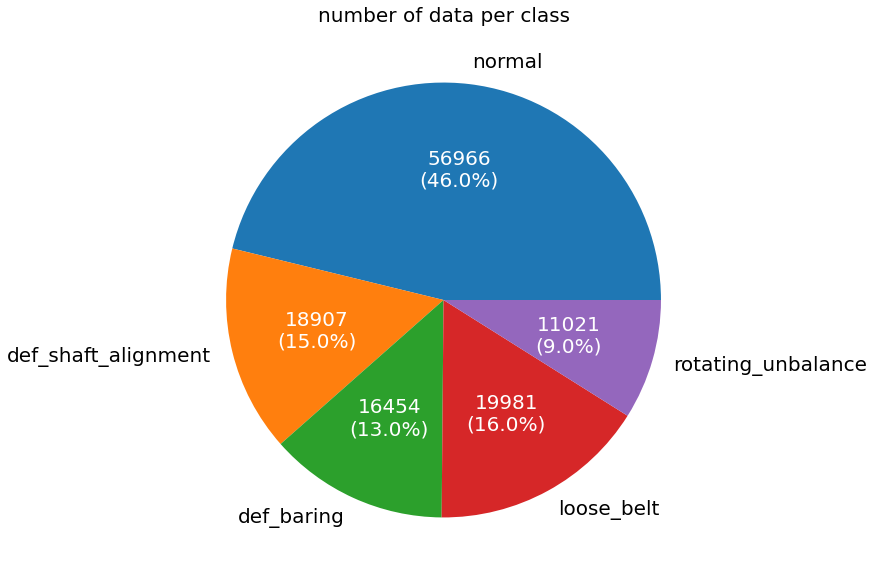

In [62]:
def absolute_value(val):
    a  = np.round(val/100. * sum(x), 0)
    return '{}\n({}%)'.format(int(a), np.round(val,0))

plt.figure(figsize=(10, 10))
plt.title('number of data per class', fontsize=20)
_, texts, values = plt.pie(x, labels = y, autopct=absolute_value, textprops={'color':"w", 'fontsize': 20})
for t in texts:
    t.set_color('black')
plt.show()

# 모델 학습
* --dataset-path 학습 데이터셋의 이미지 폴더 위치 지정
* --num-epochs 학습 횟수
* --batch-size 배치 사이즈
* --lr 런닝레이트 지정
* --checkpoints-path 모델 저장 위치
    * 10 epoch 단위로 model_epoch_{EPOCH_INDEX}.pt 파일로 저장
    * 마지막 학습 결과는 model_epoch_latest.pt 라는 이름으로 저장됨

In [95]:
!python3 model/pytorch/rnn/train.py \
--dataset-path 'dataset/vibration/train' \
--checkpoints-path 'check_points/rnn' \
--lr 0.01 \
--batch-size 256 \
--num-epochs 20

logging file path : check_points/rnn/train.log
training device : cuda
Namespace(batch_size=256, checkpoints_path='check_points/rnn', cpus=-1, dataset_path='dataset/vibration/train', epochs=20, hidden_dim=8, layers=2, lr=0.01, name='rnn', random_seed=45, use_cpu=False)
data size - trn : 98661, val : 24666
100%|#############################| 386/386 [01:25<00:00,  4.52it/s, loss=0.701]
trn Epoch:  1, time : 85.42, loss : 1.0433, f1-score : 0.5779
100%|#############################################| 3/3 [01:39<00:00, 33.17s/it]
best f1! save model. check_points/rnn/model_state_dict_best.pt
val Epoch:  1, time : 99.52, loss : 0.0057, f1-score : 0.6731
100%|#############################| 386/386 [01:24<00:00,  4.55it/s, loss=0.677]
trn Epoch:  2, time : 84.86, loss : 0.5835, f1-score : 0.7469
100%|#############################################| 3/3 [01:36<00:00, 32.30s/it]
best f1! save model. check_points/rnn/model_state_dict_best.pt
val Epoch:  2, time : 96.93, loss : 0.0036, f1-score : 0.7

# 모델 예측
* --data-path 테스트 데이터셋의 위치 지정
* --model-path 로드할 모델의 위치

In [98]:
!python3 model/pytorch/rnn/predict.py \
--dataset-path 'dataset/vibration/test_500' \
--model-path 'check_points/rnn//model_state_dict_best.pt'

2022-11-23 02:47:20,941 - loaded cuda
2022-11-23 02:47:20,954 - 1/500 - dataset/vibration/test_500/def_shaft_alignment/STFMK-20201105-LW19-1942_20201201_150744_004.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-23 02:47:20,964 - 2/500 - dataset/vibration/test_500/def_shaft_alignment/STFMK-20201105-LW19-3194_20201201_160338_004.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-23 02:47:20,975 - 3/500 - dataset/vibration/test_500/def_shaft_alignment/STFMK-20201105-LW19-3194_20201201_160405_004.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-23 02:47:20,985 - 4/500 - dataset/vibration/test_500/def_shaft_alignment/STFMK-20201105-LW19-2505_20201201_112235_004.csv, Predicted : def_shaft_alignment, Actual : def_shaft_alignment, Correct : True
2022-11-23 02:47:20,995 - 5/500 - dataset/vibration/test_500/def_shaft_alignment/STFMK-20201105-LW19-1935_20201202_145656_004.